In [16]:
%matplotlib notebook

from Bio.PDB.PDBParser import PDBParser

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

import numpy as np
import pandas as pd
from scipy.spatial import distance
import math

def average_pos(poss):
    avg_X, avg_Y, avg_Z = zip(*poss)
    avg_X = np.mean(avg_X)
    avg_Y = np.mean(avg_Y)
    avg_Z = np.mean(avg_Z)
    return avg_X, avg_Y, avg_Z

def dot_product(vec1, vec2):
    return sum([float(v1) * float(v2) for v1, v2 in zip(vec1, vec2)])

def vec_len(vec):
    return math.sqrt(float(sum([v * v for v in vec])))

def vec_angle(vec1, vec2):
    if vec1 == vec2:
        return 0.0
    angle = dot_product(vec1, vec2) / (vec_len(vec1) * vec_len(vec2))
    angle = math.degrees(math.acos(angle))
    assert 0.0 <= angle <= 360.0
    return angle
def perpendicular_proj(normal, point_plane, point):
    d = (point-point_plane).dot(normal/np.linalg.norm(normal))
    return point - d * (normal/np.linalg.norm(normal))

def calc_side_chain_vector(protres_name, protres_atoms, suppress_warnings=False):
    # composed of two vectors
    # 1. from average position of 'N', 'C' and 'O' atoms to 'CA'
    # 2. average vector from 'CA' to all other atoms except ('N', 'C' and 'O')

    # 1.
    avg_backbone = []
    CA_atom_coords = []
    avg_side_chain = []
    for a_id, coords in protres_atoms.items():
        if a_id in ['N', 'C', 'O']:
            if a_id != 'O':
                avg_backbone.append(coords)
        elif a_id == 'CA':
            CA_atom_coords.append(coords)
        else:
            if a_id == 'CB':
                avg_side_chain.append(coords)

    if len(CA_atom_coords) != 1:
        if not suppress_warnings:
            print("Warning, no CA atom in:", protres_name)
        return None, None

    assert len(CA_atom_coords) == 1
    CA_atom_coords = CA_atom_coords[0]
    CA_pos_X, CA_pos_Y, CA_pos_Z = CA_atom_coords
    backbone_X, backbone_Y, backbone_Z = average_pos(avg_backbone)

    vec_1 = (
        CA_pos_X - backbone_X, CA_pos_Y - backbone_Y, CA_pos_Z - backbone_Z)

    if protres_name == 'GLY':
        assert len(avg_side_chain) == 0
        return vec_1, CA_atom_coords
    else:
        assert len(avg_side_chain) > 0

    # 2.
    side_X, side_Y, side_Z = average_pos(avg_side_chain)
    vec_2 = (side_X - CA_pos_X, side_Y - CA_pos_Y, side_Z - CA_pos_Z)

    # angle between the two vectors has to be less than 90
    # A . B = |A| * |B| * cos(angle)
    # cos(angle) = A.B / (|A|*|B|)
    # angle = arccos(A.B / (|A|*|B|))
    # angle_deg = vec_angle(vec_1, vec_2)
    #
    # if angle_deg > 180.0:
    #    angle_deg = angle_deg - 360.0
    # if angle_deg >= 70:
    #    if not suppress_warnings:
    #        print("Warning: high angle (%s) between CA-CB and bacbone-CA vectors in %s" % (angle_deg, protres_name))
    #    return None, None
    #
    # assert angle_deg < 70.0

    # average of the two vectors
    vec = tuple(v1 + v2 for v1, v2 in zip(vec_1, vec_2))

    return vec, CA_atom_coords

def get_protein_and_rna(structure):
    protein = []
    protein_names = []
    rna = []
    rna_names = []
    for model in structure:
        for chain in model:
            for residue in chain:
                res_name = residue.get_resname().strip()
                atoms = {}
                for atom in residue:
                    atoms[atom.id] = atom.get_coord()

                if res_name in ['A', 'C', 'G', 'U']:
                    rna.append(atoms)
                    rna_names.append(res_name)
                if (res_name in [ 'ALA', 'ARG','ASN','ASP','CYS','GLU','GLN','HIS','ILE','LEU','LYS','MET',
                                 'PHE','PRO','SER','THR','TRP','TYR', 'VAL']
                        and {'CA', 'CB', 'C', 'N'}.issubset(set(atoms.keys()))) or \
                        (res_name == 'GLY' and {'CA', 'C', 'N'}.issubset(set(atoms.keys()))):

                    protein.append(atoms)
                    protein_names.append(res_name)
    return protein, rna, protein_names, rna_names

def bounding_box(atoms):
    positive = atoms[np.where(atoms[:, 2] >= 0)[0], :3]
    negative = atoms[np.where(atoms[:, 2] < 0)[0], :3]


    all_max = np.amax(atoms, axis=0)[:3]
    all_min = np.amin(atoms, axis=0)[:3]

    x_, y_, z_ = np.max(np.abs(np.vstack((all_max, all_min,))), axis=0)

    z_pos = np.amax(positive, axis=0)[2]

    if negative.shape[0] != 0:
        z_neg = np.amin(negative, axis=0)[2]
    else:
        z_neg = 0

    points = np.array([[-x_, -y_, z_neg],
                       [x_, -y_, z_neg],
                       [x_, y_, z_neg],
                       [-x_, y_, z_neg],
                       [-x_, -y_, z_pos],
                       [x_, -y_, z_pos],
                       [x_, y_, z_pos],
                       [-x_, y_, z_pos]])

    return (x_, y_, z_pos, z_neg), points

def transformation_matrix(aminoacid_atoms, aminoacid_name):
    a = aminoacid_atoms['CA']
    b = np.array(calc_side_chain_vector(aminoacid_name, aminoacid_atoms, suppress_warnings=False)[0])
    # b = aminoacid_atoms['CB']
    c1 = aminoacid_atoms['C']
    c2 = aminoacid_atoms['N']
    if (b - a).dot(c2 - c1) == 0:
        c = a + (c2 - c1)
    else:
        c1_p = perpendicular_proj(b - a, a, c1)
        c2_p = perpendicular_proj(b - a, a, c2)
        #print((c1_p - c2_p).dot(b - a))
        c = a + (c2_p - c1_p)

    d = a + np.cross((b - a), (c - a))

    u = ((d - a) / (np.linalg.norm(d - a)))
    v = ((c - a) / np.linalg.norm(c - a))
    w = ((b - a) / np.linalg.norm(b - a))
    u_m = np.append(u, 0)
    v_m = np.append(v, 0)
    w_m = np.append(w, 0)

    m = np.vstack((u_m, v_m, w_m, np.array([0, 0, 0, 1])))
    a_t = m.dot(np.append(a, 1))
    m[:, 3] = -a_t

    m2 = np.column_stack((u_m, v_m, w_m, np.array([0, 0, 0, 1])))
    m2[:, 3] = np.append(a, 1)

    #angle between b and c1->c2
    angle = (np.arccos((b.dot(c2-c1))/(np.linalg.norm(b) * np.linalg.norm(c2-c1)))) * (180/np.pi)

    return m, m2, angle

def voxelization(points, structure_id, protein_name, x_y_z=[5,5,5], xyz_sizes=np.array([13, 13, 6, 5])):

    # center = np.mean(cuboid_corners,axis=0)
    # xyzmin = center - xyz_sizes/2
    # xyzmax = center + xyz_sizes/2

    # xyzmax = np.amax(points, axis=0)[:3] + 0.001
    # xyzmin = np.amin(points, axis=0)[:3] - 0.001

    #xyz_sizes = x, y, +z, -z
    # xyzmin = np.array([-xyz_sizes[0]/2 - margin[0], -xyz_sizes[1]/2 - margin[1], -xyz_sizes[3] - margin[3]])
    # xyzmax = np.array([xyz_sizes[0]/2 + margin[0], xyz_sizes[1]/2 + margin[1], xyz_sizes[2] + margin[2]])
    xyzmin = np.array([-xyz_sizes[0]/2, -xyz_sizes[1]/2, -xyz_sizes[3]]) - np.array([2, 2, 1])
    xyzmax = np.array([xyz_sizes[0]/2, xyz_sizes[1]/2, xyz_sizes[2]]) + np.array([2, 2, 5])

    segments = []
    shape = []

    for i in range(3):
        # note the +1 in num
        # if type(x_y_z[i]) is not int:
        #     raise TypeError("x_y_z[{}] must be int".format(i))
        s, step = np.linspace(xyzmin[i], xyzmax[i], num=(x_y_z[i] + 1), retstep=True)
        segments.append(s)
        shape.append(step)

    n_x = x_y_z[0]
    n_y = x_y_z[1]
    n_z = x_y_z[2]

    structure = np.zeros((len(points), 3), dtype=int)

    structure[:, 0] = np.searchsorted(segments[0], points[:, 0]) - 1

    structure[:, 1] = np.searchsorted(segments[1], points[:, 1]) - 1

    structure[:, 2] = np.searchsorted(segments[2], points[:, 2]) - 1


    vector = np.zeros((n_x, n_y, n_z))
    for row in structure:
        x, y, z = row
        if x >=0 and y >= 0 and z >= 0:
            try:
                vector[x, y, z] = 1
            except:
                # print(x,y,z)
                continue

    # fig, axes= plt.subplots(int(np.ceil(n_z / 4)), 4, figsize=(8,8))
    #
    # plt.tight_layout()
    #
    # for i,ax in enumerate(axes.flat):
    #     if i >= len(vector):
    #         break
    #     im = ax.imshow(vector[i], cmap=cmap, interpolation="none")
    #     ax.set_title("Level " + str(i))
    #
    # fig.subplots_adjust(right=0.8)
    # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    # cbar = fig.colorbar(im, cax=cbar_ax)
    # cbar.set_label('NUMBER OF POINTS IN VOXEL')
    #
    # plt.show()

    facecolors = np.where(vector, '#7A88CCC0', '#FFD65DC0')
    edgecolors = np.where(vector, '#BFAB6E', '#7D84A6')
    filled = np.ones(vector.shape)
    x, y, z = np.meshgrid(segments[1], segments[0], segments[2])

    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 2, 2, projection='3d')

    ax.voxels(y, x, z, vector, facecolors=facecolors, edgecolors=edgecolors)
    ax.plot(points[:, 0], points[:, 1], points[:, 2], 'ko')

    ax = fig.add_subplot(1, 2, 1, projection='3d')

    ax.voxels(y, x, z, filled, facecolors=facecolors, edgecolors=edgecolors)
    ax.plot(points[:, 0], points[:, 1], points[:, 2], 'ko')

    fig.suptitle(f"Structure  ID: {structure_id}, Protein: {protein_name}")

    plt.show()
    
def plot_voxelization(structure_id, x_y_z=[17, 17, 17], x_y_z_sizes=np.array([13, 13, 6, 5]), num_figures=3):
    j = 0
    parser = PDBParser()
    structure = parser.get_structure(structure_id, 'pdb structures/' + 'pdb' + structure_id + '.ent')

    protein, rna, protein_names, rna_names = get_protein_and_rna(structure)
    
    all_protein_atoms = np.concatenate(list(map(lambda x: np.array(list(x.values())), protein)))
    all_rna_atoms = np.concatenate(list(map(lambda x: np.array(list(x.values())), rna)))

    for aminoacid_atoms, aminoacid_name in zip(protein, protein_names):
        if j >= num_figures:
            break
    
        
        min_dist = 1000
        closest = -1
        for i, rna_atoms in enumerate(rna):
            dist = np.min(distance.cdist(np.array(list(aminoacid_atoms.values())), np.array(list(rna_atoms.values()))))
            if dist < min_dist:
                min_dist = dist
                closest = i
                
        if min_dist > 4:
            continue
        else:
            j +=1

        #transformation matrix
        m, m2, angle = transformation_matrix(aminoacid_atoms, aminoacid_name)
        
        t = np.array(list(aminoacid_atoms.values()))
        t_names = list(aminoacid_atoms)
        t_1 = np.hstack((t, np.ones((t.shape[0], 1))))
        tn = np.round(m.dot(t_1.T).T, 5)[:,:3]
        
        (x_, y_, z_pos, z_neg), tocke = bounding_box(tn[:, :3])

        x, y, z = 2* x_, 2*y_, z_pos - z_neg

        print(aminoacid_name)
        print('sizes(x, y, z): ', x, y, z)
        print('angle: ', angle)

        t_rna = np.array(list(rna[closest].values()))
        t_rna_1 = np.hstack((t_rna, np.ones((t_rna.shape[0], 1))))
        tn_rna = np.round(m.dot(t_rna_1.T).T, 5)[:, :3]

        all_protein_1 = np.hstack((all_protein_atoms, np.ones((all_protein_atoms.shape[0], 1))))
        all_protein_n = np.round(m.dot(all_protein_1.T).T, 5)[:, :3]

        all_rna_1 = np.hstack((all_rna_atoms, np.ones((all_rna_atoms.shape[0], 1))))
        all_rna_n = np.round(m.dot(all_rna_1.T).T, 5)[:, :3]


        all_atoms = np.concatenate((all_protein_n, all_rna_n))
        aminoacid_closest_rna = np.concatenate((tn, tn_rna))
        voxelization(all_atoms, structure_id, aminoacid_name, x_y_z, x_y_z_sizes)
        voxelization(aminoacid_closest_rna, structure_id, aminoacid_name, x_y_z, x_y_z_sizes)




LEU
sizes(x, y, z):  7.02588 3.326 4.7229
angle:  89.07886953263191


<IPython.core.display.Javascript object>


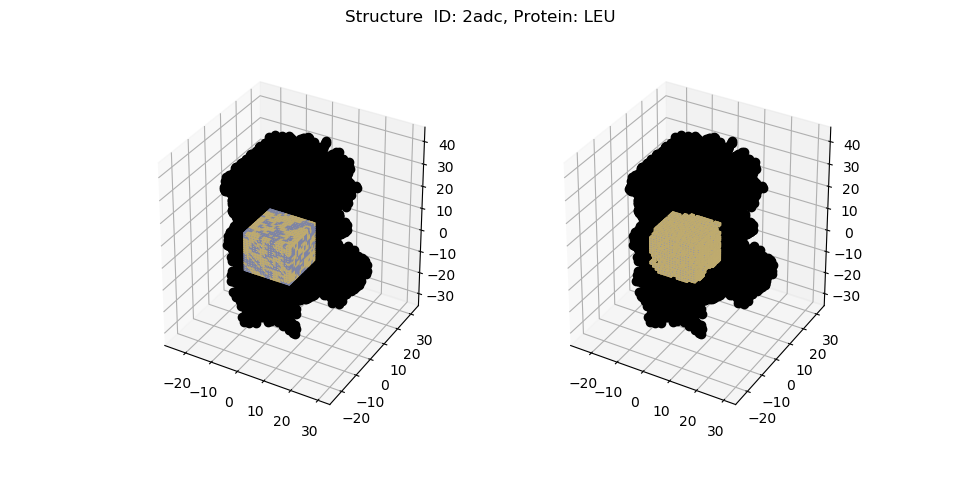

<IPython.core.display.Javascript object>


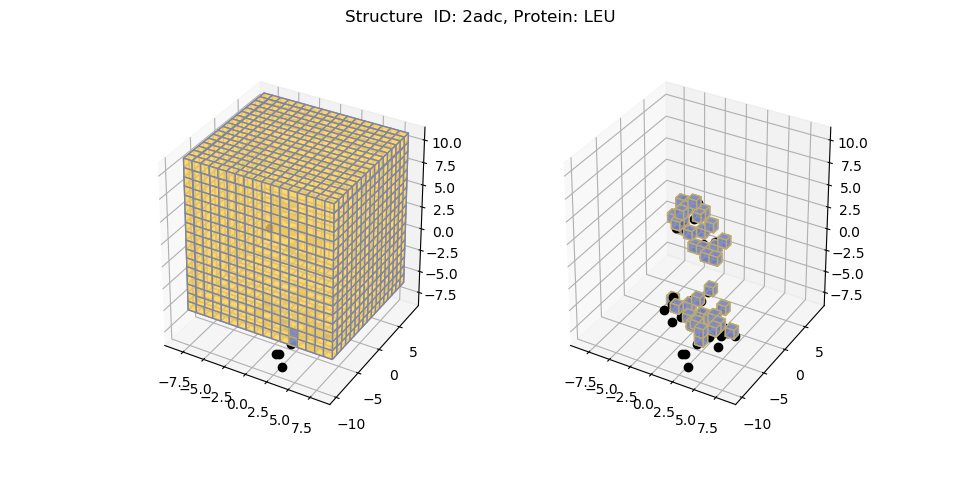

LEU
sizes(x, y, z):  5.70136 6.97856 4.56627
angle:  87.1583159606727


<IPython.core.display.Javascript object>


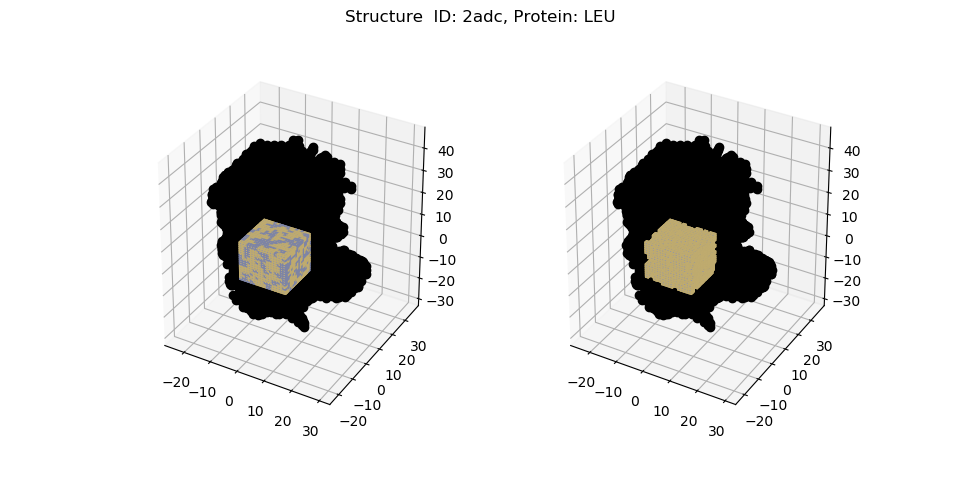

<IPython.core.display.Javascript object>


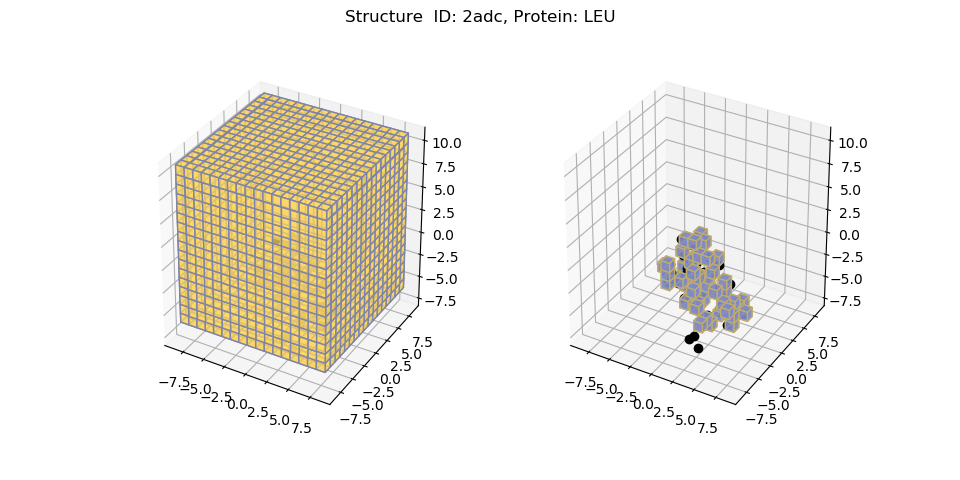

SER
sizes(x, y, z):  4.76132 4.1275 3.75584
angle:  87.00638523277493


<IPython.core.display.Javascript object>


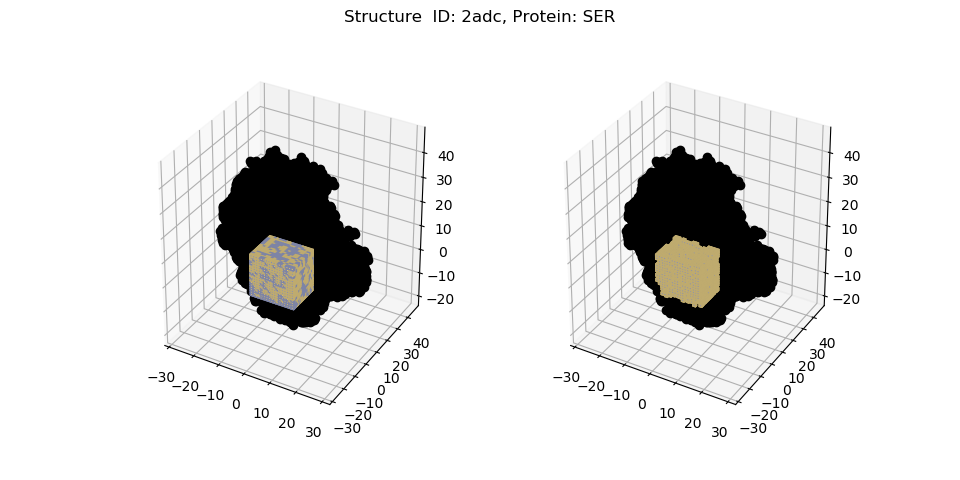

<IPython.core.display.Javascript object>


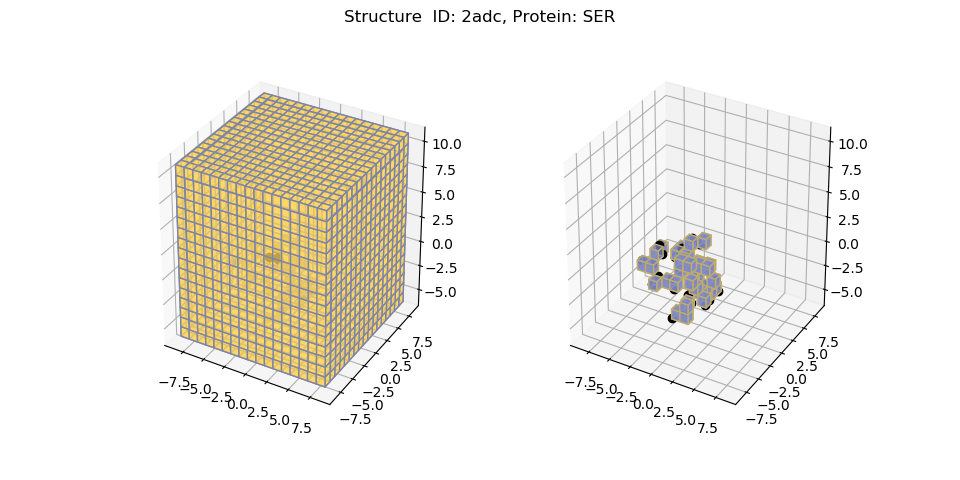

In [17]:
plot_voxelization('2adc')

LEU
sizes(x, y, z):  7.02588 3.326 4.7229
angle:  89.07886953263191


<IPython.core.display.Javascript object>


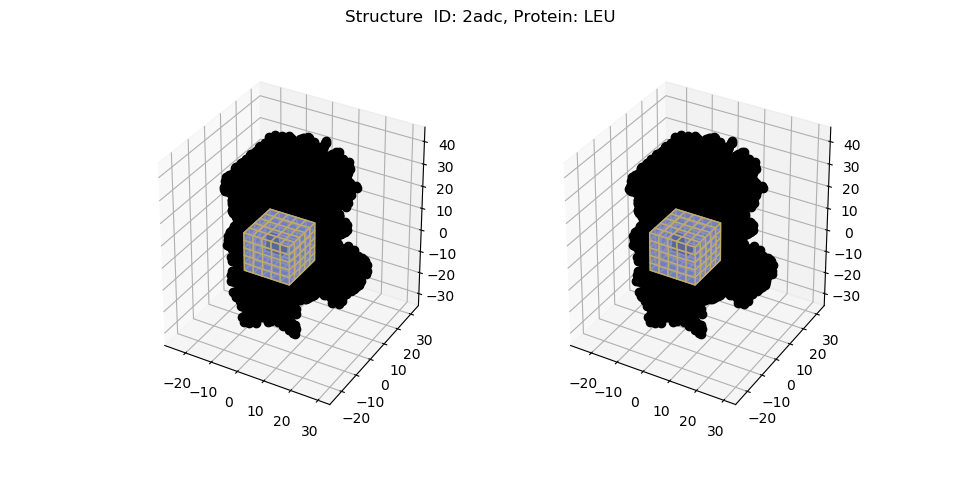

<IPython.core.display.Javascript object>


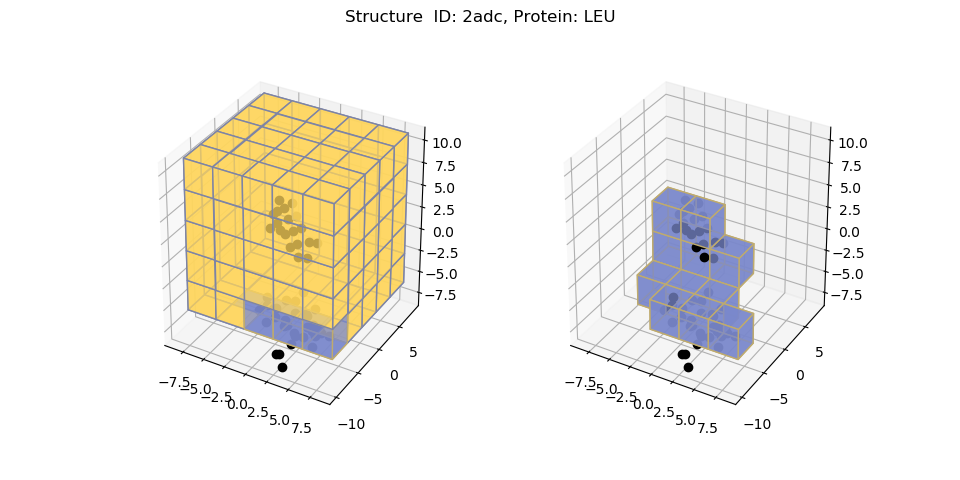

LEU
sizes(x, y, z):  5.70136 6.97856 4.56627
angle:  87.1583159606727


<IPython.core.display.Javascript object>


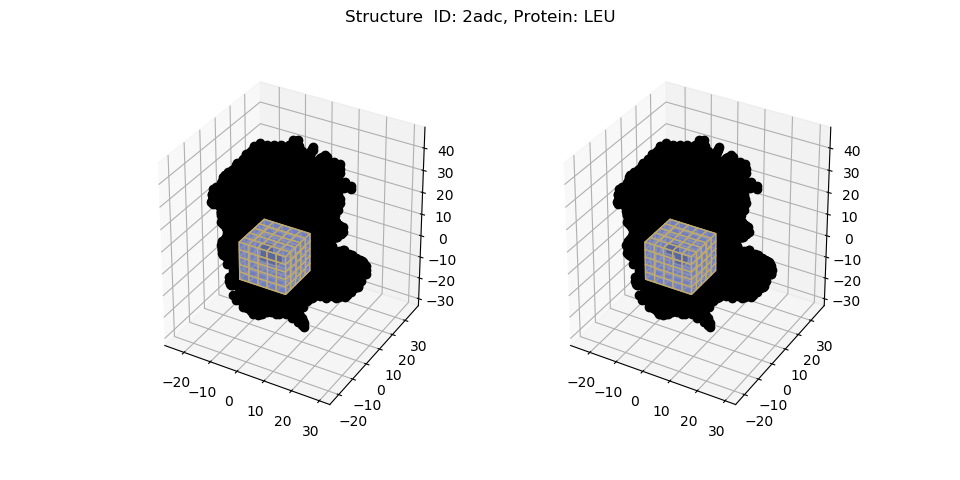

<IPython.core.display.Javascript object>


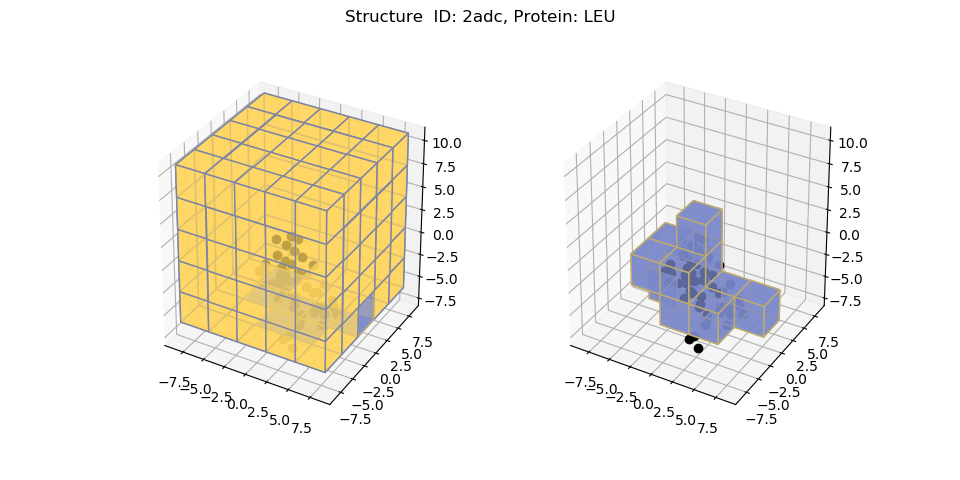

SER
sizes(x, y, z):  4.76132 4.1275 3.75584
angle:  87.00638523277493


<IPython.core.display.Javascript object>


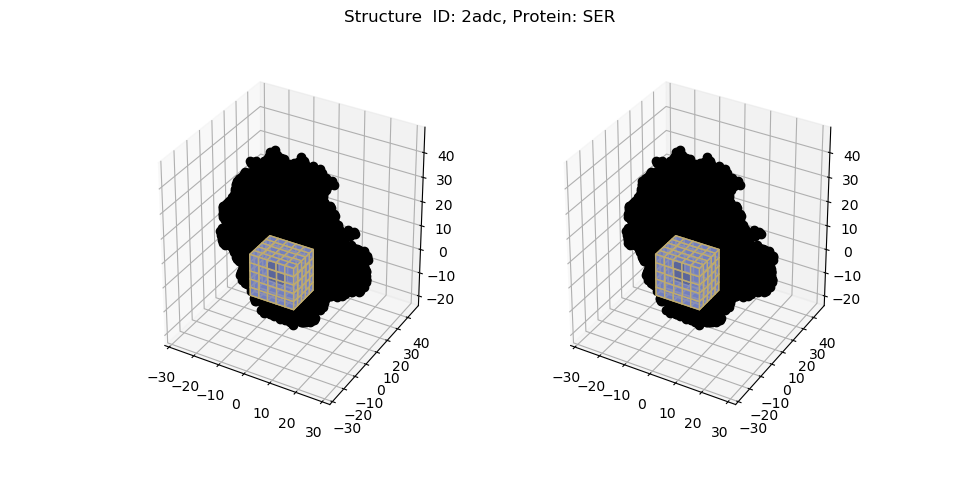

<IPython.core.display.Javascript object>


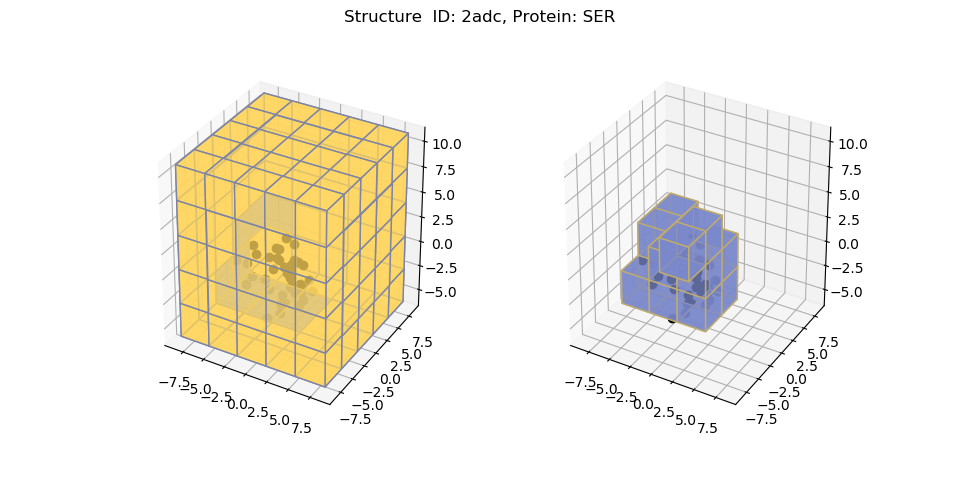

In [18]:
plot_voxelization('2adc', x_y_z=[5, 5, 5])

LEU
sizes(x, y, z):  7.02588 3.326 4.7229
angle:  89.07886953263191


<IPython.core.display.Javascript object>


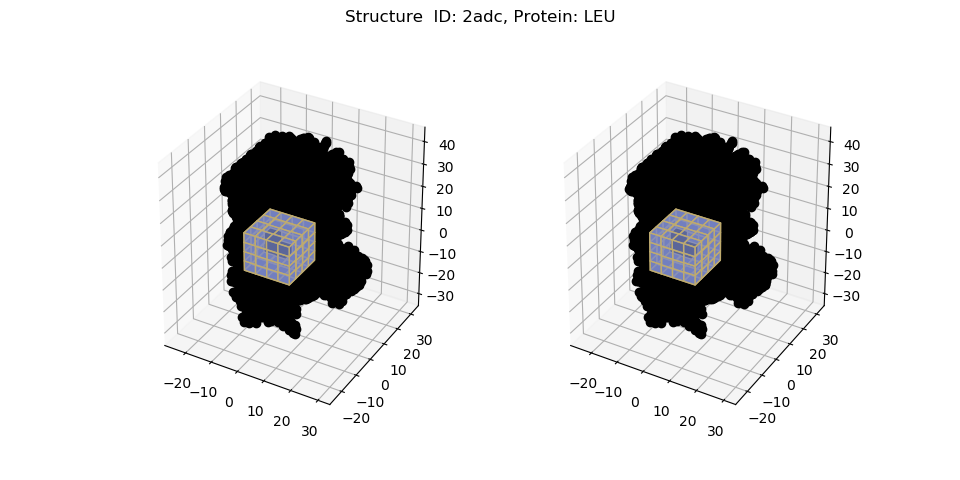

<IPython.core.display.Javascript object>


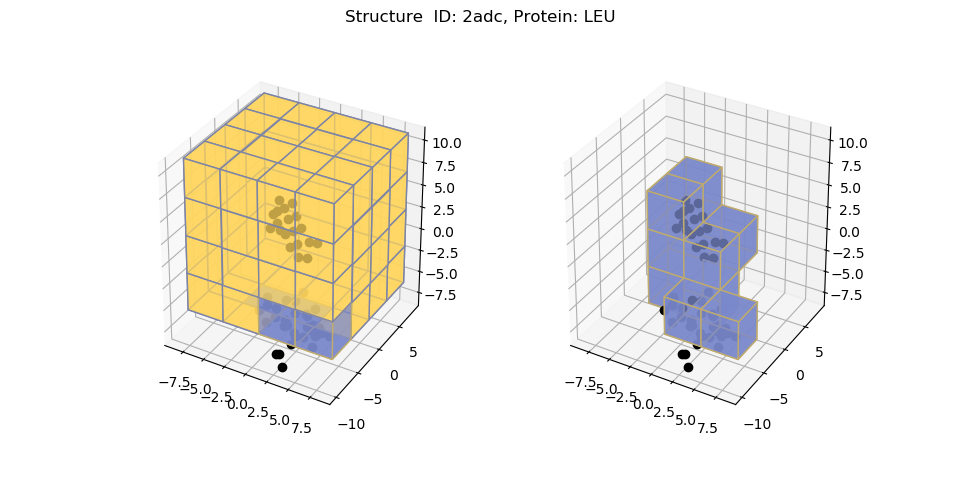

LEU
sizes(x, y, z):  5.70136 6.97856 4.56627
angle:  87.1583159606727


<IPython.core.display.Javascript object>


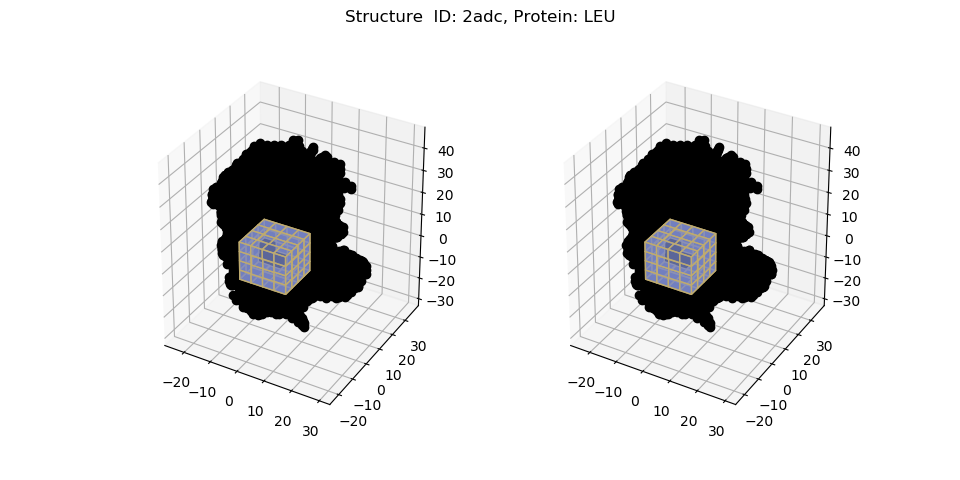

<IPython.core.display.Javascript object>


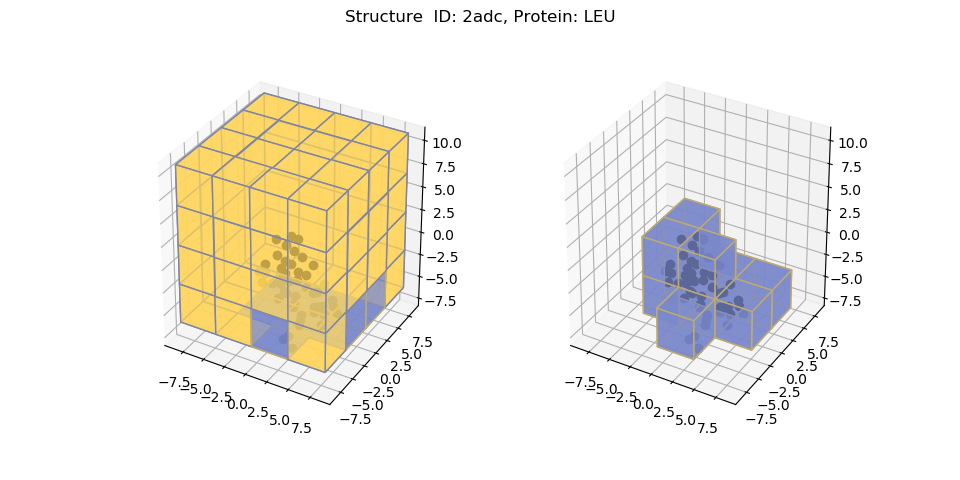

SER
sizes(x, y, z):  4.76132 4.1275 3.75584
angle:  87.00638523277493


<IPython.core.display.Javascript object>


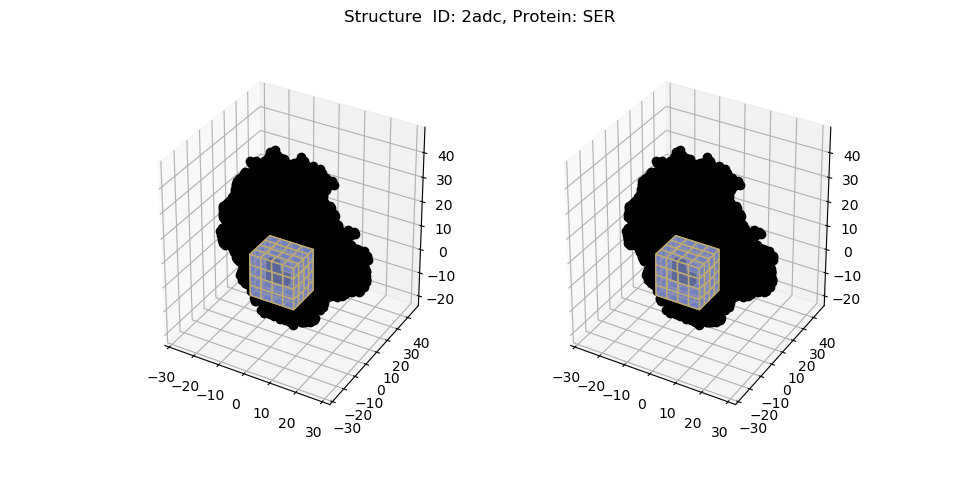

<IPython.core.display.Javascript object>


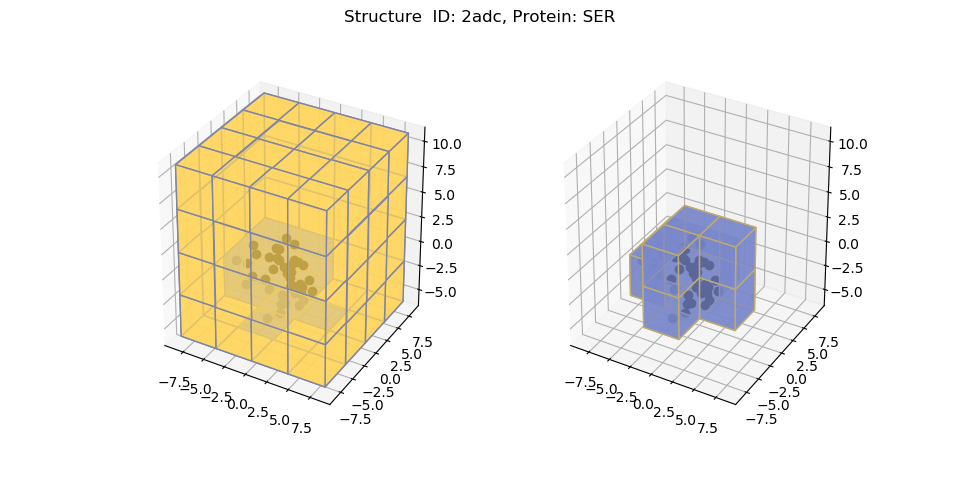

In [19]:
plot_voxelization('2adc', x_y_z=[4,4,4])